# PM2.5 Regional Analysis


In [2]:
from vayuayan import PM25Client
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import json

## 1. Understanding PM2.5 Data


## 2. Initialize PM2.5 Client


In [3]:
# Initialize PM2.5 client
pm25_client = PM25Client()

print("PM2.5 Client initialized successfully")

PM2.5 Client initialized successfully


## 3. Downloading india states GeoJSON File 


In [ ]:
# Download and save the GeoJSON file for india states

sample_geojson = gpd.read_file(
    "https://gist.githubusercontent.com/JaggeryArray/fa31964eedb0c2da023c9485772f911a/raw/02c0644de34fbae9dbac2ba0496a00772a2c28cd/india_map_states.geojson"
)

# Save to file
geojson_file = "indian_states.geojson"
sample_geojson.to_file(geojson_file, driver="GeoJSON")

## 4. Visualize the GeoJSON Region


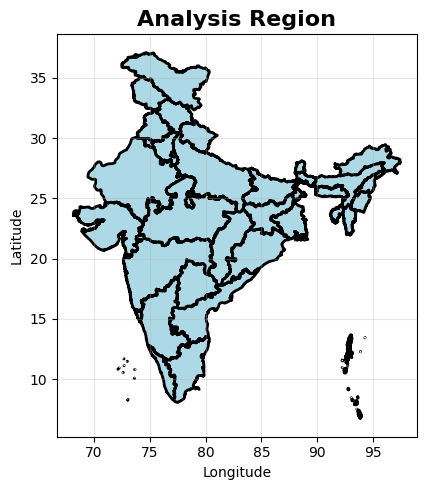


Region Details:
CRS: EPSG:4326
Number of Features: 36
Columns: ['state_name', 'state_code', 'geometry']
Name: A & N Islands
Bounds: [68.1776  6.7528 97.4129 37.0881]


In [12]:
# Load and visualize the GeoJSON
gdf = gpd.read_file(geojson_file)

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor="lightblue", edgecolor="black", linewidth=2)
ax.set_title("Analysis Region", fontsize=16, fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRegion Details:")
print(f"CRS: {gdf.crs}")
print(f"Number of Features: {len(gdf)}")
print(f"Columns: {gdf.columns.tolist()}")
print(f"Name: {gdf['state_name'].iloc[0]}")
print(f"Bounds: {gdf.total_bounds}")

## 5. Get PM2.5 Statistics for the complete India for 2023


In [24]:
# Get PM2.5 statistics for the region
# Specify year and optionally month

year = 2023
month = 2  # February (optional, leave as None for annual data)

try:
    stats = pm25_client.get_pm25_stats(geojson_file, year, month)

    print(f"PM2.5 Statistics for {year}/{month if month else 'Annual'}:")
    print(f"\nMean PM2.5: {stats['mean']:.2f} μg/m³")
    print(f"Standard Deviation: {stats['std']:.2f} μg/m³")
    print(f"Minimum PM2.5: {stats['min']:.2f} μg/m³")
    print(f"Maximum PM2.5: {stats['max']:.2f} μg/m³")

    # Interpret the results
    if stats["mean"] <= 12:
        category = "✅ Good (WHO guideline)"
    elif stats["mean"] <= 35.4:
        category = "🟢 Moderate"
    elif stats["mean"] <= 55.4:
        category = "🟡 Unhealthy for Sensitive Groups"
    elif stats["mean"] <= 150.4:
        category = "🟠 Unhealthy"
    elif stats["mean"] <= 250.4:
        category = "🔴 Very Unhealthy"
    else:
        category = "🆘 Hazardous"

    print(f"\nAir Quality Category: {category}")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nNote: This requires PM2.5 netCDF data files.")
    print("Download from: https://sites.wustl.edu/acag/datasets/surface-pm2-5/")

Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202302-202302.nc
PM2.5 Statistics for 2023/2:

Mean PM2.5: 44.21 μg/m³
Standard Deviation: 18.75 μg/m³
Minimum PM2.5: -23.80 μg/m³
Maximum PM2.5: 201.80 μg/m³

Air Quality Category: 🟡 Unhealthy for Sensitive Groups


## 6. Analyze Multiple Sub-Regions


In [27]:
# Get PM2.5 statistics for each polygon
try:
    results = pm25_client.get_pm25_stats(
        geojson_file, year=2023, month=2, group_by="state_name"
    )

    # Convert to DataFrame for better visualization
    df_results = pd.DataFrame(results)

    print("PM2.5 Statistics by State:")
    print(df_results[["state_name", "mean", "std", "min", "max", "count"]])

    # Find state with highest pollution
    worst_state = df_results.loc[df_results["mean"].idxmax()]
    print(f"\nMost Polluted State: {worst_state['state_name']}")
    print(f"Average PM2.5: {worst_state['mean']:.2f} μg/m³")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Note: This requires PM2.5 netCDF data files.")

Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202302-202302.nc
PM2.5 Statistics by State:
           state_name        mean        std        min         max   count
0       A & N Islands   26.736076   4.642200  10.559565   39.279202    7850
1      Andhra Pradesh   37.747311   7.710774 -13.700000   71.428101  140227
2   Arunachal Pradesh   25.289986   9.757482   8.589810   64.743187   76882
3               Assam   56.700302  14.021981  19.789631  112.994400   72621
4               Bihar   86.183090  17.285084  38.057251  138.052094   86164
5          Chandigarh   53.463982   2.594560  47.528309   59.226231     138
6        Chhattisgarh   43.921875   8.193904  -6.100000  167.313705  119463
7               DNHDD   39.369610   6.282200  16.576408   68.297791     687
8               Delhi  101.283966  13.680910  68.632477  130.057159    1496
9                 Goa   40.856464   3.682843  22.005735   57.911633    3333
10            Gujarat   35.799759   7.888505 -23.299999  201.796555  1

## 7. Visualize PM2.5 Distribution


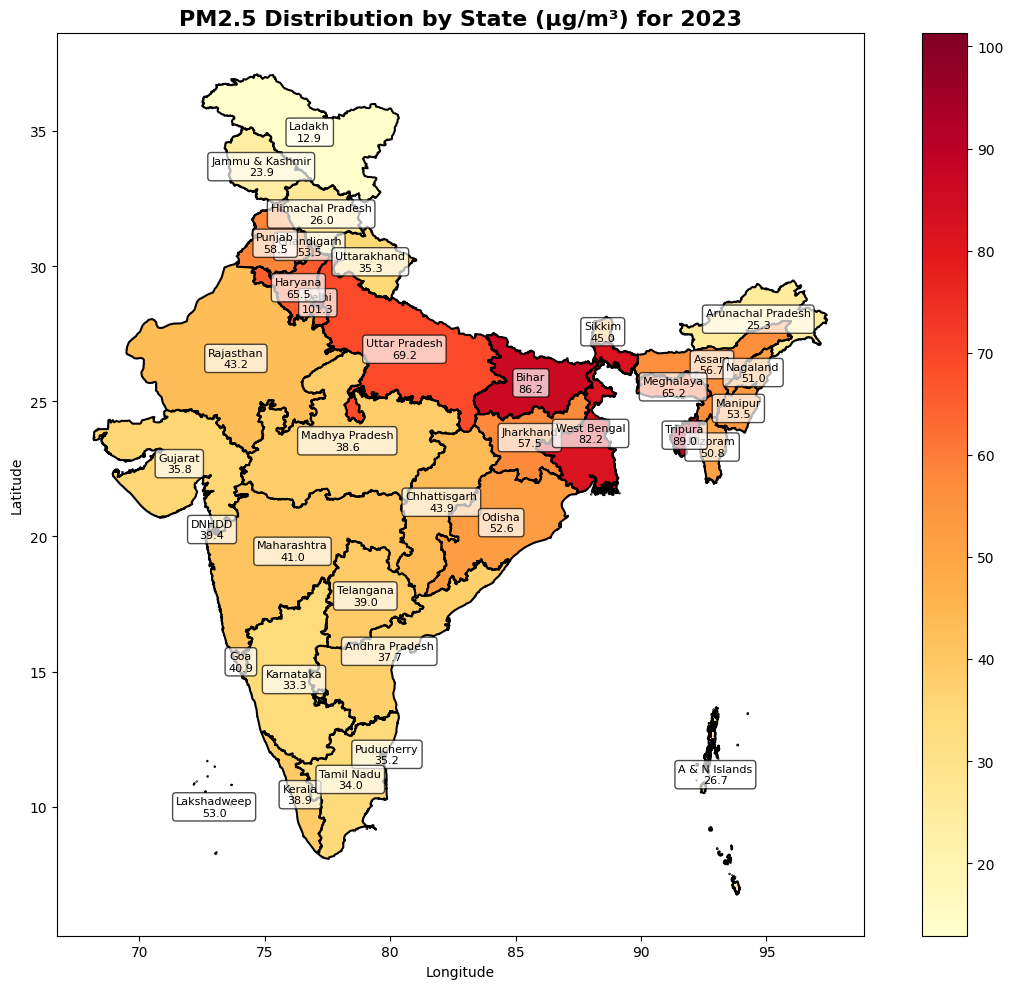

In [32]:
# Load the multi-region GeoJSON
gdf_multi = gpd.read_file(geojson_file)

# Merge with results if available
try:
    # Merge PM2.5 data with geodataframe
    gdf_with_pm25 = gdf_multi.merge(
        df_results[["state_name", "mean"]],
        left_on="state_name",
        right_on="state_name",
    )

    # Create choropleth map
    fig, ax = plt.subplots(figsize=(12, 10))
    gdf_with_pm25.plot(
        column="mean",
        ax=ax,
        legend=True,
        cmap="YlOrRd",
        edgecolor="black",
        linewidth=1.5,
    )

    # Add district labels
    for idx, row in gdf_with_pm25.iterrows():
        centroid = row.geometry.centroid
        ax.text(
            centroid.x,
            centroid.y,
            f"{row['state_name']}\n{row['mean']:.1f}",
            ha="center",
            va="center",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

    ax.set_title(
        "PM2.5 Distribution by State (μg/m³) for 2023", fontsize=16, fontweight="bold"
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.show()

except NameError:
    print("PM2.5 data not available. Run the previous cell first.")

## 8. Temporal Analysis


Analyzing monthly PM2.5 levels...

Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202301-202301.nc
Month 1: Data not available : [Errno -101] NetCDF: HDF error: 'c:\\Users\\mahes\\OneDrive\\Desktop\\Coding\\DH307\\vayuayan\\docs\\notebooks\\pm25_data\\V6GL02.04.CNNPM25.GL.202301-202301.nc'
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202302-202302.nc
Month 2: 44.21 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202303-202303.nc
Month 3: 38.77 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202304-202304.nc
Month 4: 33.03 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202305-202305.nc
Month 5: 30.89 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202306-202306.nc
Month 6: 28.29 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202307-202307.nc
Month 7: 28.57 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202308-202308.nc
Month 8: 31.72 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202309-202309.nc
Month 9: 27.58 μg/m³
Us

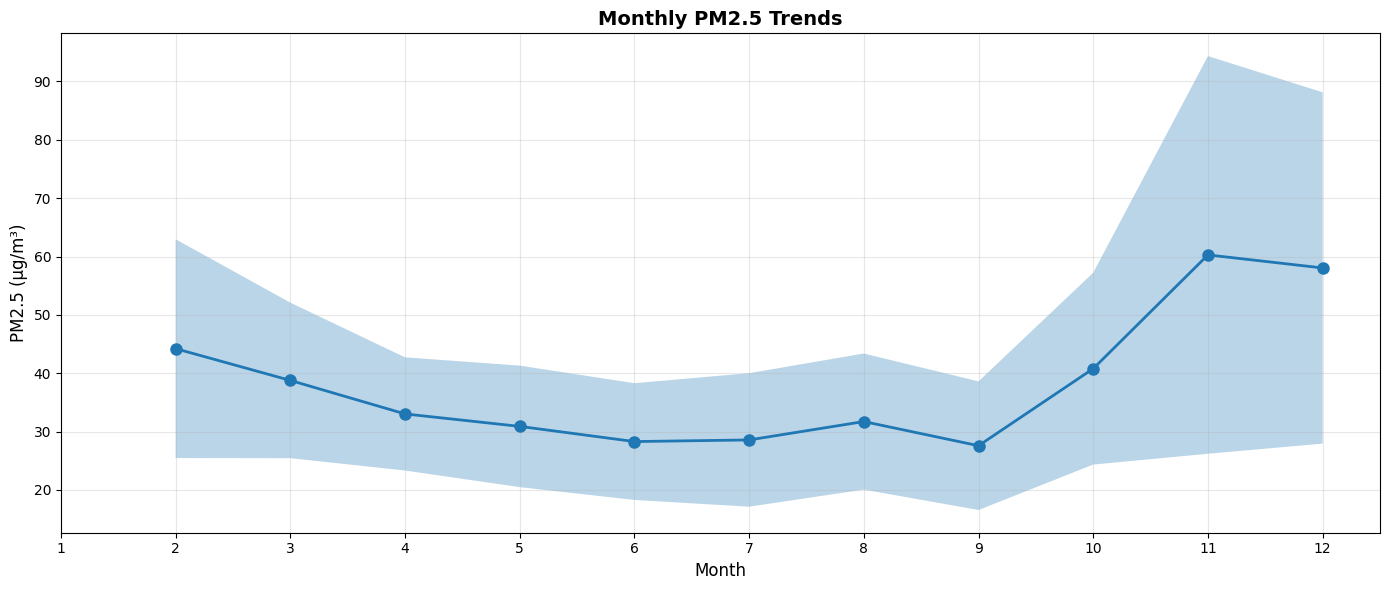


Worst Month: 11.0 (60.28 μg/m³)
Best Month: 9.0 (27.58 μg/m³)


In [29]:
# Analyze PM2.5 for multiple months
months = range(1, 13)  # All 12 months
monthly_data = []

print("Analyzing monthly PM2.5 levels...\n")

for month in months:
    try:
        stats = pm25_client.get_pm25_stats(geojson_file, 2023, month)
        monthly_data.append(
            {
                "Month": month,
                "Mean_PM25": stats["mean"],
                "Std_PM25": stats["std"],
            }
        )
        print(f"Month {month}: {stats['mean']:.2f} μg/m³")
    except Exception as e:
        print(f"Month {month}: Data not available : {e}")

if monthly_data:
    # Create DataFrame
    df_monthly = pd.DataFrame(monthly_data)

    # Plot monthly trends
    plt.figure(figsize=(14, 6))
    plt.plot(
        df_monthly["Month"],
        df_monthly["Mean_PM25"],
        marker="o",
        linewidth=2,
        markersize=8,
    )
    plt.fill_between(
        df_monthly["Month"],
        df_monthly["Mean_PM25"] - df_monthly["Std_PM25"],
        df_monthly["Mean_PM25"] + df_monthly["Std_PM25"],
        alpha=0.3,
    )
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("PM2.5 (μg/m³)", fontsize=12)
    plt.title("Monthly PM2.5 Trends", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()

    # Find worst and best months
    worst_month = df_monthly.loc[df_monthly["Mean_PM25"].idxmax()]
    best_month = df_monthly.loc[df_monthly["Mean_PM25"].idxmin()]

    print(
        f"\nWorst Month: {worst_month['Month']} ({worst_month['Mean_PM25']:.2f} μg/m³)"
    )
    print(f"Best Month: {best_month['Month']} ({best_month['Mean_PM25']:.2f} μg/m³)")

## 9. Export Results


In [30]:
# Export results to CSV
if "df_results" in locals():
    output_file = "pm25_analysis_results.csv"
    df_results.to_csv(output_file, index=False)
    print(f"State-level results saved to: {output_file}")

if "df_monthly" in locals():
    monthly_output = "pm25_monthly_trends.csv"
    df_monthly.to_csv(monthly_output, index=False)
    print(f"Monthly trends saved to: {monthly_output}")

State-level results saved to: pm25_analysis_results.csv
Monthly trends saved to: pm25_monthly_trends.csv
